# Sensitivity of barrier dynamics to overwash removal in BeachDuneManager

In the CASCADE BeachDuneManager module, we incorporate the effect of residential and commercial buildings in filtering overwash deposition (Rogers et al., 2015) by removing a percentage of the overwash deposit uniformly from the interior. This sand volume is then placed on the dune cells. Following Rogers et al., 2015, we suggest that the input variable `overwash_filter` be set between 40 and 90%, where the lower (upper) end is representative of the effect of residential (commercial) buildings in reducing overwash deposition. 

As a sensitivity test, we simulate the influence of overwash removal on barrier dynamics (width, height, shoreline change) and nourishment intervals for a community that nourishes the beach based on a minimum beach width and dune height. We expect that the barrier will drown faster due to overwash removal, but the nourishment dynamics will not be affected.

In [1]:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

datadir = "../cascade/data/pathways_data/"
Path(datadir)

from cascade import Cascade
from scripts import CASCADE_plotters as CASCADE_Plt

### Overwash removal turned off

In [2]:
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourish_now_overwash_filter_off",
    sea_level_rise_rate=0.007,  # m/yr
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_dynamics_module=False,
    dune_design_elevation=2.7,  # dune rebuilt to this elevation, m MHW when specified
    nourishment_interval=None,  # yrs
    nourishment_volume=100,  # m^3/m 
    overwash_filter=40,  # % overwash removed
)
cascade.nourishments[iB3D].overwash_removal = False  # turn overwash removal off

# loop for 100 years, but after each year, check the beach width and dune height and decide if you want to nourish
# or rebuild dune the next year with nourish_now parameter
nt = 100
bw_threshold = 30  # must be greater than 10 m
dune_threshold = 0.5  # minimum dune height above the berm crest

for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break
        
    t = cascade.barrier3d[iB3D].time_index
    if cascade.nourishments[iB3D].beach_width[t-1] < bw_threshold:
        cascade.nourish_now[iB3D] = 1
        
    DuneDomainCrest = cascade.barrier3d[iB3D].DuneDomain[t-1, :, :].max(
            axis=1
        )  # Maximum height of each row in DuneDomain
    if np.mean(DuneDomainCrest) * 10 < dune_threshold:   
        cascade.rebuild_dune_now[iB3D] = 1

 28%|██▊       | 28/99 [00:32<03:21,  2.84s/it]/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D/barrier3d/barrier3d.py:1360: RuntimeWarning: invalid value encountered in double_scalars
  Qs1 = Qs0 * Q1 / (Q1 + Q2 + Q3)
/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D/barrier3d/barrier3d.py:1361: RuntimeWarning: invalid value encountered in double_scalars
  Qs2 = Qs0 * Q2 / (Q1 + Q2 + Q3)
/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D/barrier3d/barrier3d.py:1362: RuntimeWarning: invalid value encountered in double_scalars
  Qs3 = Qs0 * Q3 / (Q1 + Q2 + Q3)
100%|██████████| 99/99 [03:36<00:00,  2.19s/it]


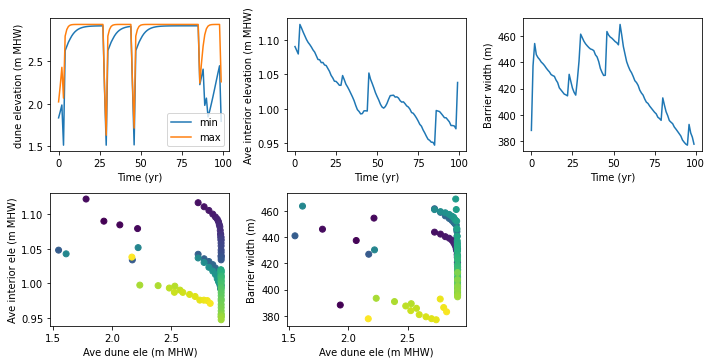

In [3]:
beach_width_overwash_removal_off = cascade.nourishments[iB3D].beach_width
nourishment_vol_overwash_removal_off = cascade.nourishments[iB3D].nourishment_volume_TS
dune_vol_overwash_removal_off = cascade.nourishments[iB3D].rebuild_dune_volume_TS

shoreline_position_overwash_removal_off = cascade.barrier3d[iB3D].x_s_TS
shoreface_toe_position_overwash_removal_off = cascade.barrier3d[iB3D].x_t_TS
shoreface_slope_overwash_removal_off = cascade.barrier3d[iB3D].s_sf_TS
shoreface_flux_overwash_removal_off = cascade.barrier3d[iB3D].QsfTS

barrier_length = 500  # m
total_ow_overwash_removal_off = np.array(cascade.barrier3d[iB3D].QowTS) * barrier_length  # m^3
net_ow_overwash_removal_off = total_ow_overwash_removal_off - cascade.nourishments[iB3D].overwash_volume_removed

(
    barrier_width_overwash_removal_off,
    dune_crest_mean_overwash_removal_off,
    barrier_height_overwash_removal_off,
    barrier_width_rate_overwash_removal_off,
    barrier_height_rate_overwash_removal_off,
    sc_rate_overwash_removal_off,
    dune_crest_min_overwash_removal_off,
    dune_crest_max_overwash_removal_off,
) = CASCADE_Plt.plot_nonlinear_stats(cascade.barrier3d, iB3D, tmin=0, tmax=100)

### Overwash removal turned on

In [4]:
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourish_now_overwash_filter_on",
    sea_level_rise_rate=0.007,  # m/yr
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_dynamics_module=False,
    dune_design_elevation=2.7,  # dune rebuilt to this elevation, m MHW when specified
    nourishment_interval=None,  # yrs
    nourishment_volume=100,  # m^3/m 
    overwash_filter=40,  # % overwash removed
)
cascade.nourishments[iB3D].overwash_removal = True  # turn overwash removal on -- default

# loop for 100 years, but after each year, check the beach width and dune height and decide if you want to nourish
# or rebuild dune the next year with nourish_now parameter
nt = 100
bw_threshold = 30  # must be greater than 10 m
dune_threshold = 0.5  # minimum dune height above the berm crest

for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break
        
    t = cascade.barrier3d[iB3D].time_index
    if cascade.nourishments[iB3D].beach_width[t-1] < bw_threshold:
        cascade.nourish_now[iB3D] = 1
        
    DuneDomainCrest = cascade.barrier3d[iB3D].DuneDomain[t-1, :, :].max(
            axis=1
        )  # Maximum height of each row in DuneDomain
    if np.mean(DuneDomainCrest) * 10 < dune_threshold:   
        cascade.rebuild_dune_now[iB3D] = 1

100%|██████████| 99/99 [02:30<00:00,  1.52s/it]


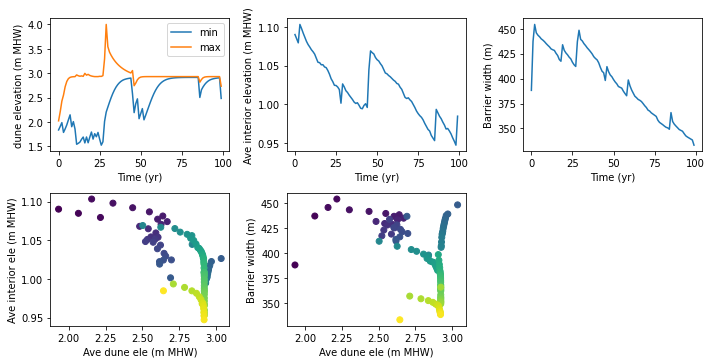

In [15]:
beach_width_overwash_removal_on = cascade.nourishments[iB3D].beach_width
nourishment_vol_overwash_removal_on = cascade.nourishments[iB3D].nourishment_volume_TS
dune_vol_overwash_removal_on = cascade.nourishments[iB3D].rebuild_dune_volume_TS

shoreline_position_overwash_removal_on = cascade.barrier3d[iB3D].x_s_TS
shoreface_toe_position_overwash_removal_on = cascade.barrier3d[iB3D].x_t_TS
shoreface_slope_overwash_removal_on = cascade.barrier3d[iB3D].s_sf_TS
shoreface_flux_overwash_removal_on = cascade.barrier3d[iB3D].QsfTS

barrier_length = 500  # m
total_ow_overwash_removal_on = np.array(cascade.barrier3d[iB3D].QowTS) * barrier_length  # m^3
net_ow_overwash_removal_on = total_ow_overwash_removal_on - cascade.nourishments[iB3D].overwash_volume_removed

(
    barrier_width_overwash_removal_on,
    dune_crest_mean_overwash_removal_on,
    barrier_height_overwash_removal_on,
    barrier_width_rate_overwash_removal_on,
    barrier_height_rate_overwash_removal_on,
    sc_rate_overwash_removal_on,
    dune_crest_min_overwash_removal_on,
    dune_crest_max_overwash_removal_on,
) = CASCADE_Plt.plot_nonlinear_stats(cascade.barrier3d, iB3D, tmin=0, tmax=100)

### Comparison plots

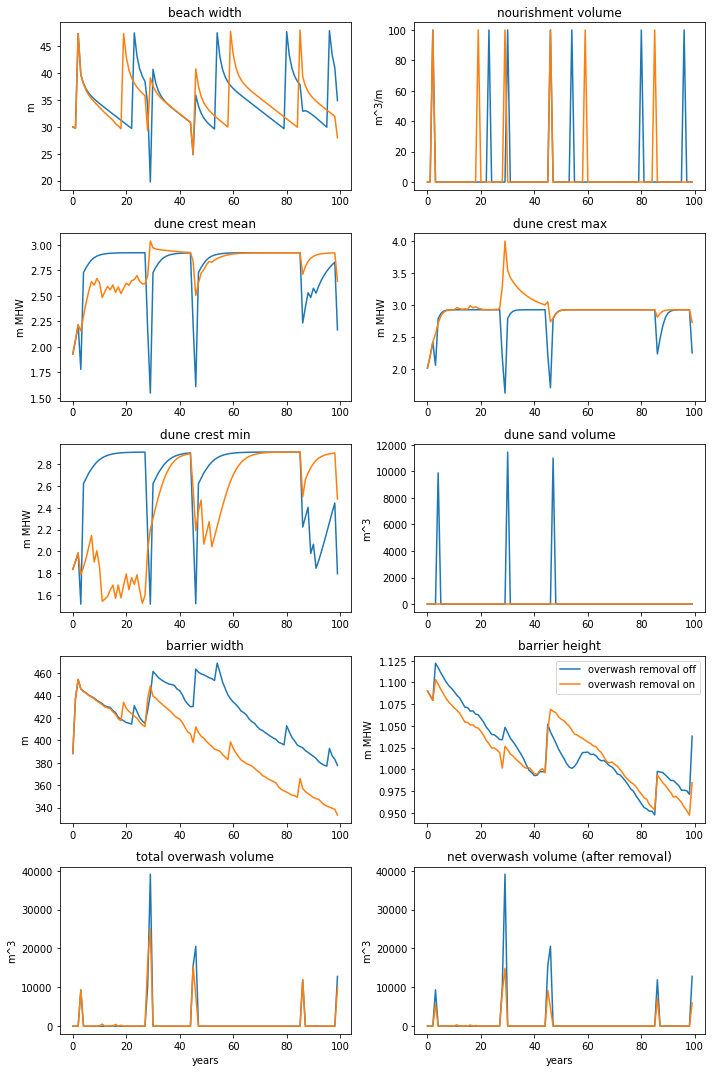

In [6]:
time = np.arange(0,100,1)

fig = plt.figure(figsize=(10,15))
plt.subplot(5,2,1)
plt.plot(time, beach_width_overwash_removal_off, time, beach_width_overwash_removal_on)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(5,2,2)
plt.plot(time, nourishment_vol_overwash_removal_off, time, nourishment_vol_overwash_removal_on)
plt.title("nourishment volume")
plt.ylabel("m^3/m")

plt.subplot(5,2,3)
plt.plot(time, dune_crest_mean_overwash_removal_off, time, dune_crest_mean_overwash_removal_on)
plt.title("dune crest mean")
plt.ylabel("m MHW")

plt.subplot(5,2,4)
plt.plot(time, dune_crest_max_overwash_removal_off, time, dune_crest_max_overwash_removal_on)
plt.title("dune crest max")
plt.ylabel("m MHW")

plt.subplot(5,2,5)
plt.plot(time, dune_crest_min_overwash_removal_off, time, dune_crest_min_overwash_removal_on)
plt.title("dune crest min")
plt.ylabel("m MHW")

plt.subplot(5,2,6)
plt.plot(time, dune_vol_overwash_removal_off, time, dune_vol_overwash_removal_on)
plt.title("dune sand volume")
plt.ylabel("m^3")

plt.subplot(5,2,7)
plt.plot(time, barrier_width_overwash_removal_off, time, barrier_width_overwash_removal_on)
plt.title("barrier width")
plt.ylabel("m")

plt.subplot(5,2,8)
plt.plot(time, barrier_height_overwash_removal_off, time, barrier_height_overwash_removal_on)
plt.title("barrier height")
plt.ylabel("m MHW")
plt.legend(["overwash removal off", "overwash removal on"])

plt.subplot(5,2,9)
plt.plot(time, total_ow_overwash_removal_off, time, total_ow_overwash_removal_on)
plt.title("total overwash volume")
plt.ylabel("m^3")
plt.xlabel("years")

plt.subplot(5,2,10)
plt.plot(time, net_ow_overwash_removal_off, time, net_ow_overwash_removal_on)
plt.title("net overwash volume (after removal)")
plt.ylabel("m^3")
plt.xlabel("years")

# plt.subplot(3,2,6)
# plt.plot(time, sc_rate_overwash_removal_off, time, sc_rate_overwash_removal_on)
# plt.title("shoreline change rate")
# plt.ylabel("m/yr")
# plt.xlabel("years")

fig.tight_layout()

I also wanted to look at shoreface dynamics:

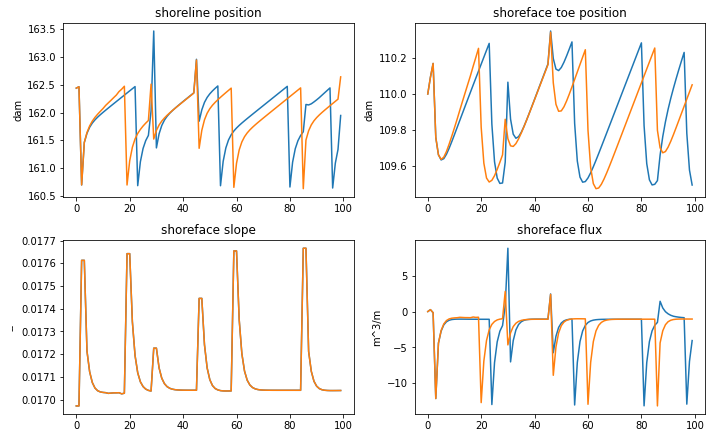

In [16]:
fig = plt.figure(figsize=(10,15))
plt.subplot(5,2,1)
plt.plot(time, shoreline_position_overwash_removal_off, time, shoreline_position_overwash_removal_on)
plt.title("shoreline position")
plt.ylabel("dam")

plt.subplot(5,2,2)
plt.plot(time, shoreface_toe_position_overwash_removal_off, time, shoreface_toe_position_overwash_removal_on)
plt.title("shoreface toe position")
plt.ylabel("dam")

plt.subplot(5,2,3)
plt.plot(time, shoreface_slope_overwash_removal_off, time, shoreface_slope_overwash_removal_on)
plt.title("shoreface slope")
plt.ylabel("--")

plt.subplot(5,2,4)
plt.plot(time, shoreface_flux_overwash_removal_off, time, shoreface_flux_overwash_removal_on)
plt.title("shoreface flux")
plt.ylabel("m^3/m")

fig.tight_layout()

Interpreting these plots -- the shoreline position appears to be constrained within a 30 m region, hooray -- but we get more insight into whats going on the shoreface. Specifically, after nourishment, the shoreface slope goes out of equilibrium, so we see negative fluxes at the next time step.